# 5. Neural network trained on base and additional features.


In [1]:
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

2023-03-17 00:29:04.106266: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-17 00:29:04.106309: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import pandas as pd
import numpy as np
import pickle

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
from keras import Sequential, layers, models

In [5]:
X_train, Y_train, X_test, Y_test=pickle.load(open("staley16+addtl_feats_split.pkl","rb"))
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((982, 10), (982,), (261, 10), (261,))

In [7]:
use_feats=X_train.columns
use_feats

Index(['stormdur_h', 'stormaccum_mm', 'peak_i15_mmh', 'logarea',
       'contributingarea_km2', 'prophm23', 'dnbr1000', 'kf', 'SedUn',
       'SuscFrac'],
      dtype='object')

In [8]:
print("Using %d out of %d features" % (len(use_feats), len(X_train.columns)))
use_feats

Using 10 out of 10 features


Index(['stormdur_h', 'stormaccum_mm', 'peak_i15_mmh', 'logarea',
       'contributingarea_km2', 'prophm23', 'dnbr1000', 'kf', 'SedUn',
       'SuscFrac'],
      dtype='object')

In [9]:
import pickle

In [12]:
ssc=pickle.load(open("feature_scaler.pkl", "rb"))
X_train_s=ssc.transform(X_train[use_feats])
X_test_s=ssc.transform(X_test[use_feats])
print(X_train_s.shape, X_test_s.shape)
pickle.dump(ssc, open("NN_standard_scaler_minpars_accum_suscfrac_nosteep_randn.pkl", "wb"))

(982, 10) (261, 10)


In [13]:
def getModel(nins, drop=0.3):
    inputs = layers.Input(shape=(nins,))
    
    x = layers.Dense(32, activation=None, kernel_initializer='glorot_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x = layers.Dropout(drop)(x) #.1
    
    x = layers.Dense(48, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('tanh')(x)    
    x = layers.Dropout(drop)(x)       #.1   
    
    x = layers.Dense(92, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x = layers.Dropout(drop)(x)       #.1
        
    x = layers.Dense(196, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('tanh')(x)    
    x = layers.Dropout(drop)(x)       #.1
    
    x = layers.Dense(392, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x = layers.Dropout(drop)(x)       #.1
    
    x = layers.Dense(196, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('tanh')(x)    
    x = layers.Dropout(drop)(x)       #.1
    
    x = layers.Dense(92, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    x = layers.Dropout(drop)(x)   
    
    x = layers.Dense(48, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('tanh')(x)    
    x = layers.Dropout(drop)(x)       #.1
    
    x = layers.Dense(32, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)     
    x = layers.Dropout(drop/2)(x) #.05
    
    x = layers.Dense(16, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('tanh')(x)    
    #x = layers.Dropout(0.05)(x)
    
    x = layers.Dense(8, activation=None, kernel_initializer='glorot_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)    
    #x = layers.Dropout(drop/8)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=predictions)
    return model

In [14]:
model=getModel(len(use_feats), drop=0.275)

2023-03-17 00:30:35.160055: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-17 00:30:35.160095: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-17 00:30:35.160130: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (83422072b6d9): /proc/driver/nvidia/version does not exist


In [15]:
import tensorflow as tf

In [ ]:
%%time
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy','mae','BinaryIoU','AUC'])  #msle
history = model.fit(X_train_s, Y_train, validation_split=0.0, epochs=1000, 
                    batch_size=100, verbose=0)

In [16]:
for key in history.history.keys():
    print(key, history.history[key][-1])

loss 0.27733027935028076
accuracy 0.8645620942115784
mae 0.1748506724834442
binary_io_u 0.7106822729110718
auc 0.9373681545257568


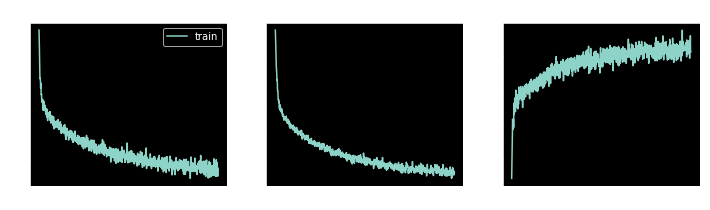

In [17]:
fig,ax=plt.subplots(ncols=3, figsize=(12,3))

for n,metric in enumerate(["loss", "mae", "binary_io_u"]):
    ax[n].plot(history.history[metric], label='train')
    #ax[n].plot(history.history["val_" + metric], label='test')
    ax[n].set_title(metric)
ax[0].legend()

In [18]:
Y_train_pred=model.predict(X_train_s)

31/31 [==============================] - 0s 2ms/step


In [24]:
jaccard_score(Y_train, np.round(Y_train_pred)), roc_auc_score(Y_train, Y_train_pred)
#print(accuracy_score(Y_train, np.round(Y_train_pred)))

(0.7483870967741936, 0.9795025833302485)

In [25]:
Y_test_pred=model.predict(X_test_s)

9/9 [==============================] - 0s 4ms/step


In [26]:
jaccard_score(Y_test, np.round(Y_test_pred)), roc_auc_score(Y_test, Y_test_pred)

(0.5416666666666666, 0.9217162554426706)

In [27]:
from sklearn.metrics import roc_curve, RocCurveDisplay

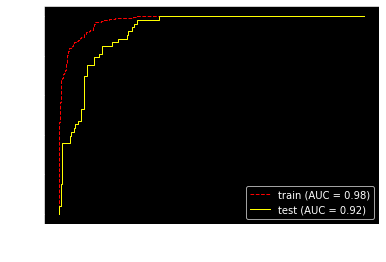

In [28]:
fig,ax=plt.subplots()
RocCurveDisplay.from_predictions(Y_train, Y_train_pred, ax=ax, linewidth=1, 
                                 color='red', name='train', linestyle="dashed")
RocCurveDisplay.from_predictions(Y_test, Y_test_pred, ax=ax, linewidth=1, color='yellow', name='test')

In [29]:
Y_test_proba=np.zeros((len(Y_test_pred),2), dtype=float)
Y_test_proba[:,0] = 1.-Y_test_pred[:,0]
Y_test_proba[:,1] = Y_test_pred[:,0]

In [30]:
odir="totaccum_sediment_susc_frac_randn"
ofile=odir + "/NN_proba.pkl"
pickle.dump(Y_test_proba, open(ofile,"wb"))

In [31]:
!ls -l $odir

total 60
-rw-r--r-- 1 droten droten 4329 Aug 27 22:34 'Gradient Boosting_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Aug 27 22:34 'K-Nearest Neighbors_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Aug 27 22:34 'Logistic Regression_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Aug 27 23:17  NN_proba.pkl
-rw-r--r-- 1 droten droten 4329 Aug 27 22:34 'Naive Bayes_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Aug 27 22:34 'Random Forest_proba.pkl'
-rw-r--r-- 1 droten droten 4329 Aug 27 22:34  SVC_proba.pkl
-rw-r--r-- 1 droten droten 2239 Aug 27 22:34 'Staley (2016)_proba.pkl'


Re-train using all the data:

In [54]:
X_train_s.shape, Y_train.shape

((982, 10), (982,))

Merge training and testing set, and use to re-train model.

In [53]:
X_traintest_s=np.append(X_train_s, X_test_s, axis=0)
Y_traintest=np.append(Y_train, Y_test)
print(X_traintest_s.shape, Y_traintest.shape)

(1243, 10) (1243,)


In [62]:
modelp=getModel(len(use_feats), drop=0.275)

In [63]:
optp = tf.keras.optimizers.Adam(learning_rate=0.001)
modelp.compile(optimizer=optp, loss='binary_crossentropy',metrics=['accuracy','mae','BinaryIoU','AUC'])  #msle
historyp = modelp.fit(X_traintest_s, Y_traintest, validation_split=0.0, epochs=1000, 
                    batch_size=100, verbose=0)

In [64]:
for key in historyp.history.keys():
    print(key, historyp.history[key][-1])

loss 0.24757428467273712
accuracy 0.8825422525405884
mae 0.1641954630613327
binary_io_u 0.7355458736419678
auc 0.9497954845428467


In [65]:
Y_traintest_pred=modelp.predict(X_traintest_s)
jaccard_score(Y_traintest, np.round(Y_traintest_pred)), roc_auc_score(Y_traintest, Y_traintest_pred)

39/39 [==============================] - 1s 5ms/step


(0.7308781869688386, 0.9758527576365845)

Save model for debris flow forecasting:

In [59]:
modelp.save('NNp_11layer_minpars_accum_suscfrac_randn.h5')

In [35]:
!md5sum *.h5

3c1a51bcdcf2b8caaee3637de6a30ecd  NN_11layer_minpars_accum_suscfrac_randn.h5
